In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
from argparse import Namespace
import cv2
import torch
import glob
from PIL import Image 
from transforms3d.quaternions import mat2quat, quat2mat


skew = lambda v: np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
pose2fund = lambda K1, K2, R, t: np.linalg.inv(K2).T @ R @ K1.T @ skew((K1 @ R.T).dot(t.reshape(3,)))

def crop_from_bottom_right(w, h, target_ratio=1.5, min_ratio=1.3, max_ratio=1.7):
    ratio = w / h    
    if ratio < min_ratio or ratio > max_ratio:
        return None
    if ratio == target_ratio:
        return 0, 0
    if ratio > target_ratio:
        # Cut the width
        dh = h % 2
        ht = h - dh
        dw = w - ht * target_ratio
        wt = w - dw

    if ratio < target_ratio:
        # Cut the height
        dw = w % 3
        wt = w - dw    
        dh = h - wt / target_ratio
        ht = h - dh
    return dw, dh



def cal_relative_pose(c1, c2, q1, q2):
    """Calculate relative pose between two cameras
    Args:
    - c1: absolute position of the first camera
    - c2: absolute position of the second camera
    - q1: orientation quaternion of the first camera
    - q2: orientation quaternion of the second camera
    Return:
    - (t12, q12): relative pose giving the transformation from the 1st camera to the 2nd camera coordinates, 
                  t12 is translation, q12 is relative rotation quaternion 
    """
    r1 = quat2mat(q1)
    r2 = quat2mat(q2)
    r12 = r2.dot(r1.T)
    q12 = mat2quat(r12)
    t12 = r2.dot(c1 - c2)
    return (t12, q12)


def sampson_distance(pts1, pts2, F, eps=1e-8):
    """Calculate symmetric epipolar distance between 2 sets of points
    Args:
        - pts1, pts2: points correspondences in the two images, 
          each has shape of (num_points, 2)
        - F: fundamental matrix that fulfills x2^T*F*x1=0, 
          where x1 and x2 are the correspondence points in the 1st and 2nd image 
    Return:
        A vector of (num_points,), containing root-squared epipolar distances
          
    """
    # Homogenous coordinates
    ones = np.ones((pts1.shape[0], 1))    
    pts1 = np.concatenate([pts1, ones], axis=1)
    pts2 = np.concatenate([pts2, ones], axis=1)
    
    # l2=F*x1, l1=F^T*x2
    l2 = np.dot(F, pts1.T) # 3,N
    l1 = np.dot(F.T, pts2.T)
    dd = np.sum(l2.T * pts2, 1)  # Distance from pts2 to l2   
    d = dd ** 2 / (eps + l1[0, :] ** 2 + l1[1, :] ** 2 + l2[0, :] ** 2 + l2[1, :] ** 2)   
    return d

args = Namespace(base_dir='/storage/group/cvpr/zhouq/MegaDepth_undistort',
                 save_dir='.',                
                 min_overlap_ratio=0.35, im_target_ratio=1.5, 
                 max_scene_pairs=50)

base_dir = args.base_dir
scene_info_dir = os.path.join(base_dir, 'scene_info')

# Output dir for log and match_pairs npy
save_dir = args.save_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
min_overlap_ratio = args.min_overlap_ratio
im_target_ratio = args.im_target_ratio
max_scene_pairs = args.max_scene_pairs  # At most take such amount of pairs per scene

scene_overlappings = []
match_dict = {}  # {'ims', 'pairs'}
total_valid_pairs = 0
selected_pairs = 0
scene_files = sorted(os.listdir(scene_info_dir))
print('Start process {} scenes ......'.format(len(scene_files)))
for scene_file in scene_files:
    scene_name = scene_file.split('.')[0]        
    
    # Load scene information
    scene_info_path = os.path.join(scene_info_dir, scene_file)
    try:        
        scene_info = dict(np.load(scene_info_path, allow_pickle=True))        
    except Exception as err:
        print('Can not open {}: {}'.format(scene_file, err.args))
        continue

    # Select valid pairs
    overlap_matrix = scene_info['overlap_matrix']
    scale_ratio_matrix = scene_info['scale_ratio_matrix']
    valid =  np.logical_and(
        np.logical_and(
            overlap_matrix >= min_overlap_ratio,
            overlap_matrix < 1
        ),
        scale_ratio_matrix <= np.inf
    )
    valid_pair_ids = np.vstack(np.where(valid))   # 2,N
    valid_num = valid_pair_ids.shape[1]
    total_valid_pairs += valid_num
    
    # Load scene information    
    image_paths = scene_info['image_paths']
    depth_paths = scene_info['depth_paths']
    points3D_id_to_2D = scene_info['points3D_id_to_2D']
    points3D_id_to_ndepth = scene_info['points3D_id_to_ndepth']
    intrinsics = scene_info['intrinsics']
    poses = scene_info['poses']   

    # Iterate over pairs
    imlist = {}
    pairs = []
    selected_ids = np.arange(valid_num)
    np.random.shuffle(selected_ids)
    for pair_idx in selected_ids:
        idx1 = valid_pair_ids[0, pair_idx]
        idx2 = valid_pair_ids[1, pair_idx]
        overlap = overlap_matrix[idx1, idx2]

        # Check image ratios
        K1 = intrinsics[idx1]
        K2 = intrinsics[idx2]  
        w1, h1 = 2 * K1[:2, 2]
        w2, h2 = 2 * K2[:2, 2]                    
        if w1 >= h1 and w2 >= h2:
            # Landscape pairs            
            crop1 = crop_from_bottom_right(w1, h1, target_ratio=im_target_ratio)
            crop2 = crop_from_bottom_right(w2, h2, target_ratio=im_target_ratio)
            if not crop1 or not crop2:
                continue
        else:
            # Ignore portrait and mixed pairs 
            continue            

        # Find common 3D points of the curremt image pair
        common_pts3D = np.array(list(
            points3D_id_to_2D[idx1].keys() &
            points3D_id_to_2D[idx2].keys()
        ))

        # Remove matches with bad depth scale
        pt_nd1 = np.array([points3D_id_to_ndepth[idx1][pid] for pid in common_pts3D])
        pt_nd2 = np.array([points3D_id_to_ndepth[idx2][pid] for pid in common_pts3D])
        scale_ratio = np.maximum(pt_nd1 / pt_nd2, pt_nd2 / pt_nd1)
        common_pts3D = common_pts3D[np.where(scale_ratio <= np.inf)[0]]

        # Obtain 2D correspondences
        matches = []
        for pid in common_pts3D:
            p1 = points3D_id_to_2D[idx1][pid]
            p2 = points3D_id_to_2D[idx2][pid]
            matches.append((p1[0], p1[1], p2[0], p2[1]))
        matches = np.array(matches)
        
       # Calculate relative poses    
        pose1 = poses[idx1]
        r1 = pose1[:3, :3]
        t1 = pose1[:3, 3]
        c1 = - r1.T.dot(t1)  # Center of cameras in the world coordinates
        q1 = mat2quat(r1)

        pose2 = poses[idx2]
        r2 = pose2[:3, :3]
        t2 = pose2[:3, 3]
        c2 = - r2.T.dot(t2)
        q2 = mat2quat(r2)

        t, q = cal_relative_pose(c1, c2, q1, q2)
        R = quat2mat(q)

        # Check epipolar errors
        K1 = intrinsics[idx1]
        K2 = intrinsics[idx2]  
        F = pose2fund(K1, K2, R, t)

        pts1 = matches[:, :2]
        pts2 = matches[:, 2:]
        dist  = sampson_distance(pts1, pts2, F)
        print(np.mean(dist), np.where(dist < 0.1)[0].shape)
        if np.mean(dist) > 1:
            print('Inaccurate matches or intrinsics')
            continue        
            
        # Wrap up pair data
        im1_name = image_paths[idx1].replace('Undistorted_SfM/', '')
        im2_name = image_paths[idx2].replace('Undistorted_SfM/', '')
        
        if im1_name not in imlist:
            imlist[im1_name] = Namespace(name=im1_name, crop=crop1)      
        if im2_name not in imlist:
            imlist[im2_name] = Namespace(name=im2_name, crop=crop2)         
        
        # Customize what you want to save 
        pairs.append(Namespace(im1=im1_name, im2=im2_name, matches=matches, overlap=overlap, 
                               K1=K1, K2=K2, t=t, q=q, R=R, crop1=crop1, crop2=crop2))
        scene_overlappings.append(overlap)
        if len(pairs) >= max_scene_pairs:
            break    

    if len(pairs) > 0:
        selected_pairs += len(pairs)
        scene_dict = dict(ims=list(imlist.values()), pairs=pairs)
        match_dict[scene_name] = scene_dict
    print('Scene:{} ims:{} total valid pairs:{} selected pairs:{}'.format(scene_name, len(imlist), valid_num, len(pairs)))                
match_npy_path = os.path.join(save_dir, 'match_pairs.ov{}_imrat{}.pair{}.npy'.format(min_overlap_ratio, im_target_ratio, max_scene_pairs))
np.save(match_npy_path, match_dict)
print('Save mathces to {}.'.format(match_npy_path))    
print('Finished, total valid pairs:{} used scenes:{} pairs:{} '.format(total_valid_pairs, len(match_dict), selected_pairs))
bins = bins=np.arange(0.15, 1.01, 0.1)
hist = np.histogram(scene_overlappings, bins=bins)[0]
print('Overlapping bins={} hist={}'.format(bins, hist))     

(790, 1185, 3) (790, 1185, 3)
Plot 803 matches


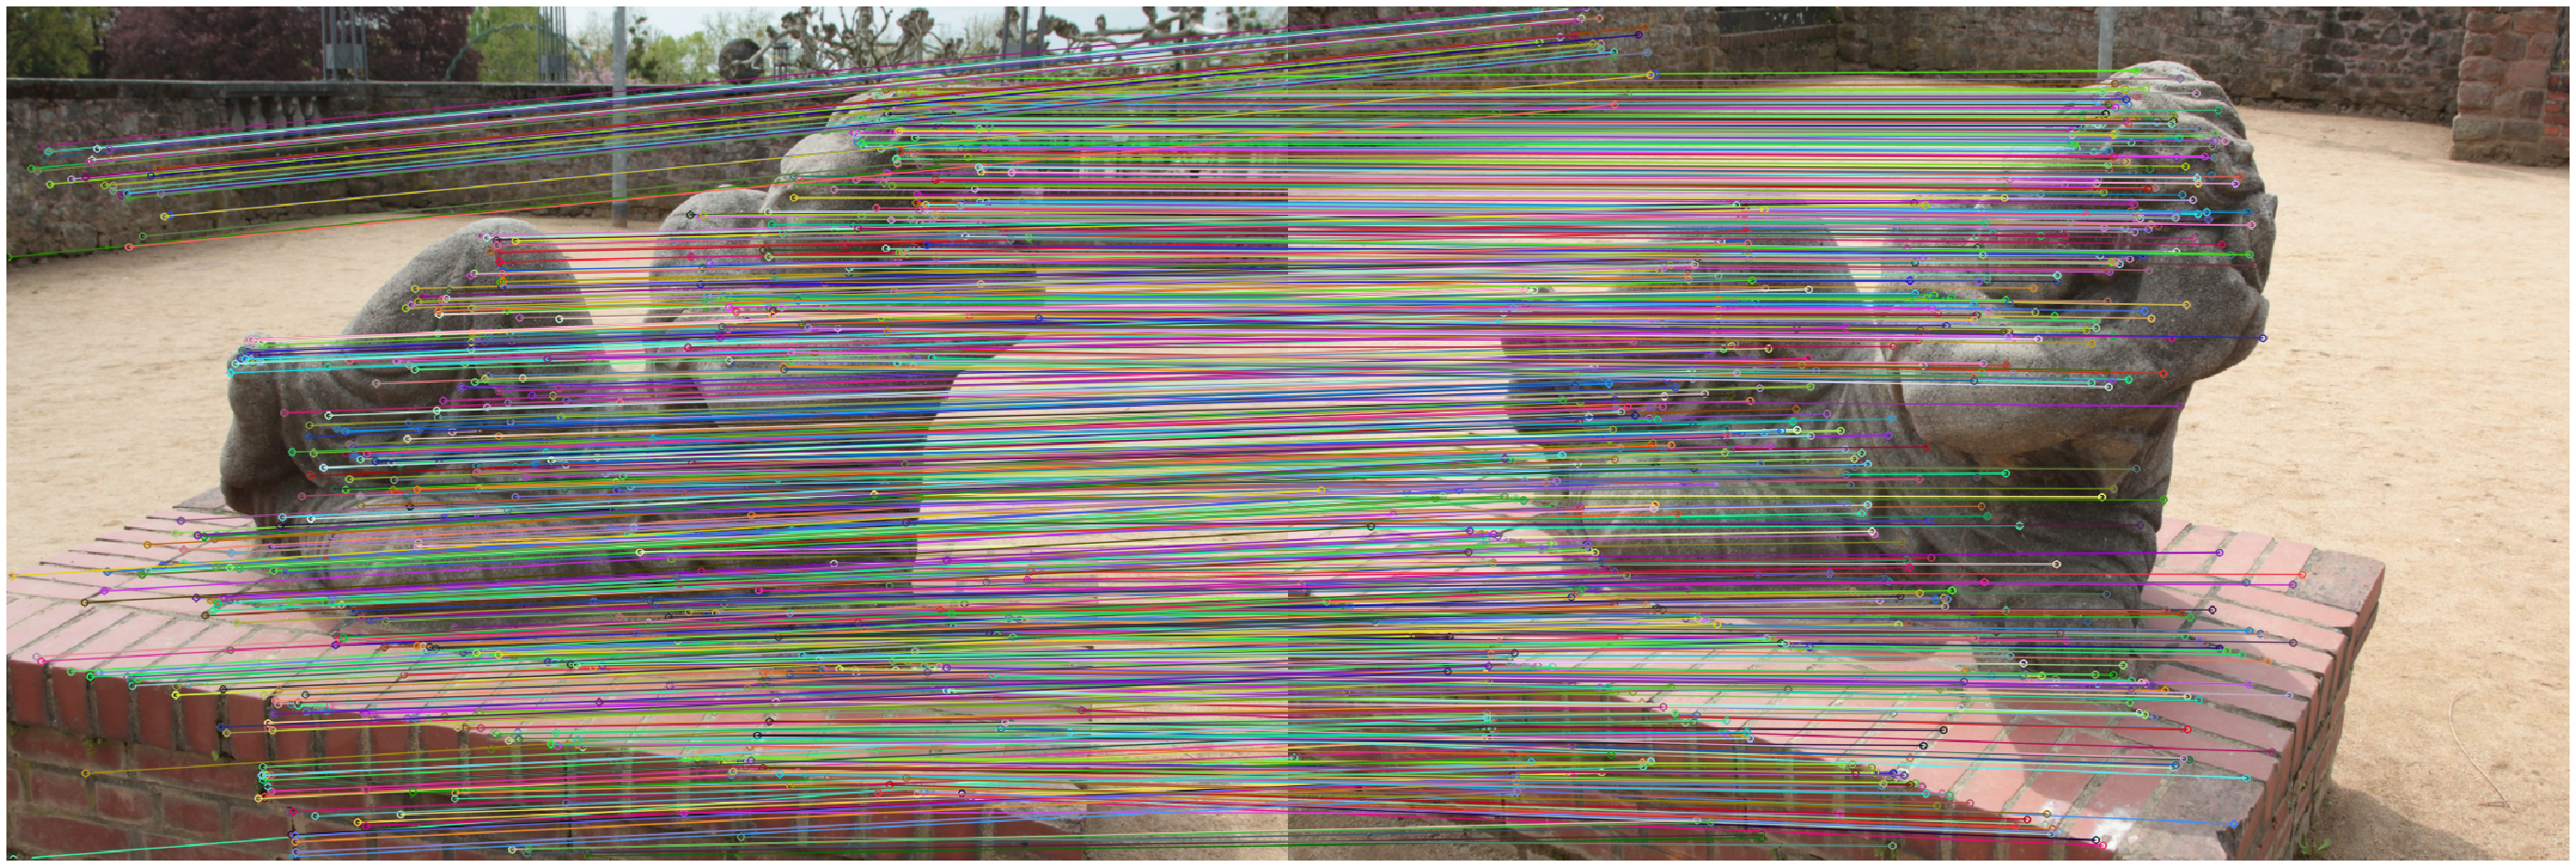

In [5]:
def plot_matches_cv(im1, im2, matches, inliers=None, Npts=1000, radius=3, dpi=350, sav_fig=None, ret_im=False):
    import matplotlib.pyplot as plt
    import cv2

    # Read images and resize        
    if isinstance(im1, torch.Tensor):            
        im1 = im1.squeeze().permute(1, 2, 0).cpu().data.numpy()
        im2 = im2.squeeze().permute(1, 2, 0).cpu().data.numpy()
        I1 = undo_normalize_scale(im1)
        I2 = undo_normalize_scale(im2)           
    elif isinstance(im1, str):
        I1 = np.array(Image.open(im1))
        I2 = np.array(Image.open(im2))
    else:
        I1 = im1
        I2 = im2

    """
    # Key points and matches
    p1s = []
    p2s = []
    dmatches = []
    for i, (x1, y1, x2, y2) in enumerate(matches):
        p1s.append(cv2.KeyPoint(x1, y1, 1))
        p2s.append(cv2.KeyPoint(x2, y2, 1)) 
        if i in inliers:
            dmatches.append(cv2.DMatch(i, i, 1))
    """
    
    if inliers is None:
        inliers = np.arange(len(matches))
        
    if Npts < len(inliers):
        inliers = inliers[:Npts]        
    
    # Only matches
    p1s = []
    p2s = []
    dmatches = []
    for i, (x1, y1, x2, y2) in enumerate(matches):
        if i in inliers:    
            p1s.append(cv2.KeyPoint(x1, y1, 1))
            p2s.append(cv2.KeyPoint(x2, y2, 1))
            j = len(p1s) - 1
            dmatches.append(cv2.DMatch(j, j, 1))

    print('Plot {} matches'.format(len(dmatches)))

    I3 = cv2.drawMatches(I1, p1s, I2, p2s, dmatches, None)

    fig = plt.figure(figsize=(50, 50))
    axis = fig.add_subplot(1, 1, 1)
    axis.imshow(I3)
    axis.axis('off') 
    if sav_fig:        
        fig.savefig(sav_fig, dpi=150,  bbox_inches='tight')      
    plt.show()    
    if ret_im:
        return I3
    
    
im1_ref = image_paths[idx1].replace('Undistorted_SfM', base_dir)
im2_ref = image_paths[idx2].replace('Undistorted_SfM', base_dir)    

im1 = np.array(Image.open(im1_ref))
im2 = np.array(Image.open(im2_ref))

dw1, dh1 = crop1
dw2, dh2 = crop2
im1 = im1[0:int(h1-dh1), 0: int(w1-dw1)]
im2 = im2[0:int(h2-dh2), 0: int(w2-dw2)]
print(im1.shape, im2.shape)

pts1 = matches[:, :2]
pts2 = matches[:, 2:]
dist  = sampson_distance(pts1, pts2, F)

# if np.mean(dist) > 1e-5:
#     print('Inaccurate matches or intrinsics')

# Visualize matches
plot_matches_cv(im1, im2, matches)
      

In [ ]:
dist